In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
#import librosa
#import utils
#import ast
import pickle
#import fma_utils
#import kapre
#from kapre.time_frequency import Spectrogram, Melspectrogram
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_io as tfio


#import os
#import shutil
#from IPython.display import display, Audio


In [2]:
#import tensorflow as tf
#import tensorflow as tf
#print(tf.__version__)
#tf.config.list_physical_devices('GPU')

In [3]:
print(44100*1.5)
print(44100*28.5)
print(44100*27)

66150.0
1256850.0
1190700


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUDIO_DIR = 'data/fma_small'
SR = 44100
BATCH_SIZE = 8
INP_SHAPE = (1190700, 2)
START = 441000  #1.5 seconds from start
END = 882000  #28.5 seconlds from start

In [27]:
from tensorflow.compat.v1 import ConfigProto
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [ ]:
#load 
fma_multi = pickle.load(open("saved/fma_multi.p", "rb"))

In [ ]:
fma_multi.head()

In [ ]:
#use the 8000 track balanced subset for baseline modeling
subset = fma_multi.index[fma_multi['subset'] == 'small']

In [ ]:
fma_small = fma_multi.loc[subset]

In [ ]:
fma_small['filepath'] = fma_small['filepath'].str.replace('large','small')

In [ ]:
fma_small

In [ ]:
#drop very short files
len_d={}
channels_d={}
for idx,row in fma_small.iterrows():
    audio = tfio.audio.AudioIOTensor(row['filepath'],tf.float32)   
    len_d.update({idx:int(audio.shape[0])})
    channels_d.update({idx:int(audio.shape[1])})

channels_df=pd.DataFrame.from_dict(channels_d,orient='index')
channels_df.sort_values(by=0,inplace=True)
len_df=pd.DataFrame.from_dict(len_d,orient='index')
len_df.sort_values(by=0,inplace=True)

In [ ]:
channels_df[0].value_counts()

In [ ]:
dl = len_df.iloc[:17]
drop_list = list(dl.index)
dl2 = channels_df.iloc[:85]
drops2=list(dl2.index)

for i in drop_list:
    if i in drops2:
        drops2.remove(i)
drop3=drop_list+drops2

In [ ]:
pickle.dump(drop3,open("saved/drop3.p","wb"))

In [ ]:
drop3=pickle.load(open("saved/drop3.p","rb"))

In [ ]:
fma_small.drop(drop3, inplace=True)


In [ ]:
len(fma_small)

In [ ]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = fma_small.index[fma_small['split'] == 'training']
val = fma_small.index[fma_small['split'] == 'validation']
test = fma_small.index[fma_small['split'] == 'test']

In [ ]:
print('training set size: ', len(train))
print('validation set size: ', len(val))
print('test set size: ', len(test))

In [ ]:
enc = LabelEncoder()

X_train = fma_small['filepath'].loc[train]
X_val = fma_small['filepath'].loc[val]
X_test = fma_small['filepath'].loc[test]
y_train = enc.fit_transform(fma_small['genre_top'].loc[train])
y_val = enc.transform(fma_small['genre_top'].loc[val])
y_test = enc.transform(fma_small['genre_top'].loc[test])

In [ ]:
def parse_audio_orig(filename,  label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
   
    length=int(audio.shape[0])
    #audio = audio.to_tensor()
    audio = audio[10000:length-10000]
    
    #if source is mono, copy to second channel
    if audio.shape[1]==1:
        paddings = [[0, 0], [0, 1]]
        audio = tf.pad(audio, paddings, "SYMMETRIC")
    
    if length < END:
        pad_len = abs(END-length)+20000
        paddings = [[0, pad_len], [0, 0]]
        audio = tf.pad(audio, paddings, "SYMMETRIC")
    audio = audio[START:END] #crop to uniform size
    return audio, label

In [ ]:
def parse_audio(filename,  label):
    """returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
   
    length=int(audio.shape[0])
    #audio = audio.to_tensor()
    #audio = audio[10000:length-10000]    
   
    audio = audio[START:END] #crop to uniform size
    return audio, label

In [13]:
#parse_audio('data/fma_large/000/000207.mp3',1)
audio = tfio.audio.AudioIOTensor('data/fma_small/029/029355.mp3')

In [14]:
audio=audio[START:END]
#audio_tensor = tf.squeeze(audio_slice, axis=[-1])

In [15]:
print(audio)

tf.Tensor(
[[-0.28557882 -0.3076603 ]
 [-0.32922053 -0.34307703]
 [-0.36303848 -0.3685807 ]
 ...
 [ 0.40637183  0.40876493]
 [ 0.35322148  0.35691938]
 [ 0.28746384  0.29345515]], shape=(441000, 2), dtype=float32)


In [16]:
spectrogram = tfio.experimental.audio.spectrogram(
    audio, nfft=512, window=512, stride=256)


In [23]:
spectrogram

<tf.Tensor: shape=(441000, 1, 257), dtype=float32, numpy=
array([[[1.15804369e-05, 1.15804369e-05, 1.15804378e-05, ...,
         1.15804341e-05, 1.15804351e-05, 1.15804369e-05]],

       [[1.29135342e-05, 1.29135342e-05, 1.29135342e-05, ...,
         1.29135306e-05, 1.29135315e-05, 1.29135342e-05]],

       [[1.38735004e-05, 1.38735004e-05, 1.38735013e-05, ...,
         1.38734968e-05, 1.38734977e-05, 1.38735004e-05]],

       ...,

       [[1.53860474e-05, 1.53860474e-05, 1.53860492e-05, ...,
         1.53860419e-05, 1.53860437e-05, 1.53860474e-05]],

       [[1.34345646e-05, 1.34345646e-05, 1.34345655e-05, ...,
         1.34345619e-05, 1.34345619e-05, 1.34345646e-05]],

       [[1.10457495e-05, 1.10457504e-05, 1.10457504e-05, ...,
         1.10457477e-05, 1.10457468e-05, 1.10457495e-05]]], dtype=float32)>

In [18]:
mel_spectrogram = tfio.experimental.audio.melscale(
    spectrogram, rate=SR, mels=128, fmin=0, fmax=10000)

In [24]:
mel_spectrogram

<tf.Tensor: shape=(441000, 1, 128), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.7532013e-05, 3.0111321e-05, 2.8941296e-05]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         3.0701394e-05, 3.3577624e-05, 3.2272914e-05]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         3.2983677e-05, 3.6073718e-05, 3.4672019e-05]],

       ...,

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         3.6579699e-05, 4.0006624e-05, 3.8452101e-05]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         3.1940126e-05, 3.4932404e-05, 3.3575048e-05]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.6260814e-05, 2.8721031e-05, 2.7605029e-05]]], dtype=float32)>

In [20]:
# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(
    mel_spectrogram, top_db=80)

In [22]:
dbscale_mel_spectrogram

<tf.Tensor: shape=(441000, 1, 128), dtype=float32, numpy=
array([[[-286.02475, -286.02475, -286.02475, ..., -233.02908,
         -231.23804, -232.03067]],

       [[-286.02475, -286.02475, -286.02475, ..., -230.84991,
         -229.05887, -229.8515 ]],

       [[-286.02475, -286.02475, -286.02475, ..., -229.41582,
         -227.62479, -228.41742]],

       ...,

       [[-286.02475, -286.02475, -286.02475, ..., -227.34619,
         -225.55518, -226.34781]],

       [[-286.02475, -286.02475, -286.02475, ..., -230.0588 ,
         -228.26776, -229.0604 ]],

       [[-286.02475, -286.02475, -286.02475, ..., -233.97452,
         -232.18347, -232.9761 ]]], dtype=float32)>

TypeError: Invalid shape (441000, 1, 128) for image data

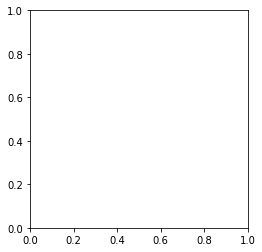

In [25]:
plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [ ]:
a=parse_audio('data/fma_large/000/000207.mp3',1)

In [ ]:
print(a)

In [ ]:
def audio_gen(filename,label):
    """
    returns audio trimmed to [START:END] sample indexes and scaled to -1 to 1
    """    
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
   
    length=int(audio.shape[0])
    #audio = audio.to_tensor()
    audio = audio[10000:length-10000]    
   
    audio = audio[START:END] #crop to uniform size
    yield audio, label

In [ ]:
#X_train_ds=tf.data.Dataset.from_tensor_slices(X_train)
#X_val_ds=tf.data.Dataset.from_tensor_slices(X_val)
#X_test_ds=tf.data.Dataset.from_tensor_slices(X_test)
#y_train_ds=tf.data.Dataset.from_tensor_slices(y_train)
#y_val_ds=tf.data.Dataset.from_tensor_slices(y_val)
#y_test_ds=tf.data.Dataset.from_tensor_slices(y_test)


train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
#data pipeline
def get_data(dataset):
    dataset = dataset.shuffle(buffer_size=len(train), seed=42)
    dataset = dataset.map(parse_audio, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [ ]:
train_ds = get_data(train_ds)
val_ds = get_data(val_ds)
test_ds = get_data(test_ds)

In [ ]:
#define model
keras.backend.clear_session()
model = models.Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, input_shape=INP_SHAPE))

model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(4))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(8))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_ds, 
                    epochs=10,                    
                    validation_data=val_ds)

In [ ]:
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=INP_SHAPE, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))

model.add(Melspectrogram(sr=SR, n_mels=128, 
          n_dft=512, n_hop=256, input_shape=INP_SHAPE, 
          return_decibel_melgram=True,
          trainable_kernel=True, name='melgram'))

In [ ]:
!conda list cudatoolkit

In [ ]:
#define model
#Define Model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=4, activation='relu', input_shape=INP_SHAPE))
model.add(layers.Conv1D(64, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
#Compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
model.summary()

In [ ]:
!yes | pip insta